---
# Simulate pRF-experiment

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import nideconv as nd
from nideconv import simulate
import nibabel as nb
from prfpy import *
from linescanning import *
from linescanning import glm,image,prf
import scipy as sp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import yaml

opj = os.path.join
base, place = utils.get_base_dir()

base_dir = opj(base, 'projects', 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures', 'prf')


In [2]:
# simulate data
# define stimulus design
# perform analysis as normal
# update stimulus design

In [3]:
design_fn = utils.get_file_from_substring("vis_design.mat", opj(base_dir, 'derivatives', 'prf', 'sub-007'))
print(design_fn)

if os.path.exists(design_fn):
    design_matrix = loadmat(design_fn)
    print(f"Shape dm = {design_matrix['stim'].shape}")

    params = np.array([2.283,-0.742,1.039,0.189,-0.163,0.01,18.,0.189,1.,0.745])
    print(f"Params = {params}")
else:
    raise ValueError(f"Could not find {design_fn}")


/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-007/vis_design.mat
Shape dm = (270, 270, 225)
Params = [ 2.283 -0.742  1.039  0.189 -0.163  0.01  18.     0.189  1.     0.745]


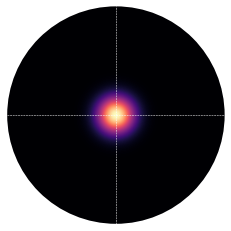

In [4]:
vf_extent = [-5, 5]
prf_stim = stimulus.PRFStimulus2D(screen_size_cm=70, screen_distance_cm=225, design_matrix=design_matrix['stim'],TR=1.5)

prf_array = prf.make_prf(prf_stim, size=params[2])
prf.plot_prf(prf_array, vf_extent)


In [5]:
# starting stimulus design
design_matrix = loadmat(opj(base_dir, 'derivatives', 'prf', 'sub-005', 'vis_design.mat'))

# define model
gg = model.Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                   filter_predictions=False,
                                   filter_type='sg',
                                   filter_params={'window_length': 300, 'polyorder': 1})

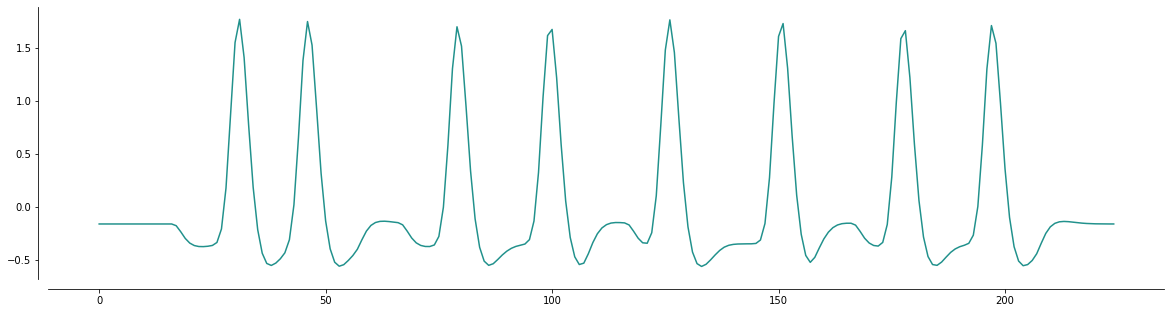

In [8]:
x = np.squeeze(gg.return_prediction(*params).T)
glm.plot_array(x, xkcd=False, figsize=(20,5))

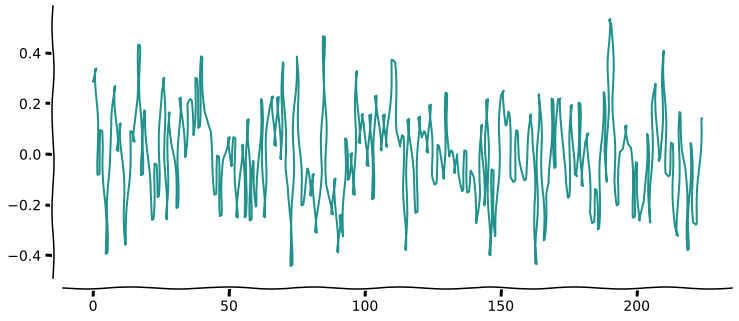

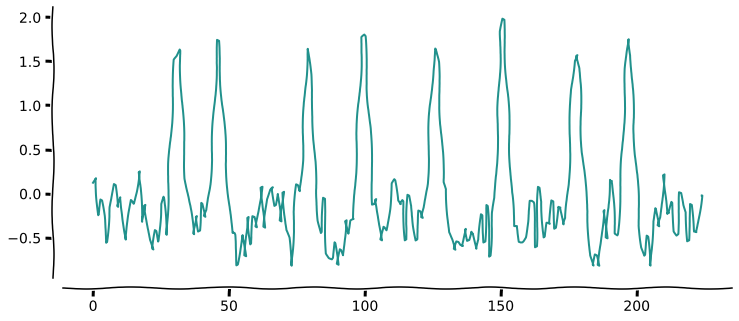

In [9]:
# add noise to data
noise = np.random.normal(0, 0.2, x.shape[0])
glm.plot_array(noise, xkcd=True)
synth_fmri = x+noise
glm.plot_array(synth_fmri, xkcd=True)

max tstat (vox 0) = 48.26
max beta (vox 0) = 1.0


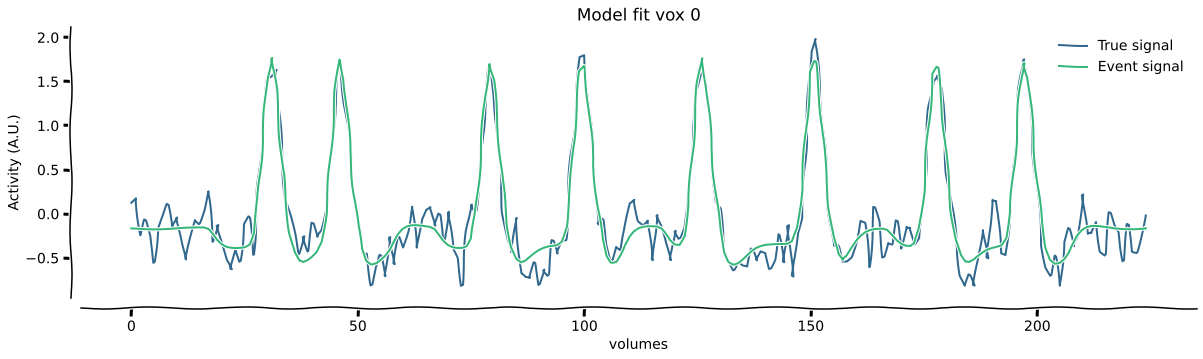

In [10]:
# get fit
betas,x_conv = glm.fit_first_level(x, synth_fmri, make_figure=True, xkcd=True)

In [9]:
synth_fmri.shape

(225,)

# Actually simulate with nideconv

In [10]:
# # get peaks for onset times
# peaks, _ = sp.signal.find_peaks(x, height=0)
# onsets_tr = list(peaks-5)

# with plt.xkcd():
#     fig = plt.figure(figsize=(12,3))
#     plt.plot(x)
#     plt.plot(peaks, x[peaks], "x")
#     sns.despine(offset=10)

#     for ii in onsets_tr:
#         plt.axvline(ii, color='r')
#     plt.show()


In [11]:
# onsets_sec = [i*1.5 for i in onsets]
# onsets_sec

In [12]:
# stim_pars = {'name': 'stim',
#              'mu_group': 1.5,  # Positive response for stimulus presentation
#              'std_group': 0,
#              'onsets': onsets_tr}

# conditions = [stim_pars]

# data, onsets, parameters = simulate.simulate_fmri_experiment(conditions,
#                                                              run_duration=x.shape[0],
#                                                              noise_level=0.05)

# glm.plot_array([data,x], xkcd=True)


---
# Fit model to synthetic BOLD

In [13]:
gf = fit.Norm_Iso2DGaussianFitter(gg, synth_fmri[...,np.newaxis].T)
old_params = np.array((*params[:3], params[-1]))[np.newaxis,...]
old_params.shape


(1, 4)

In [14]:
surround_amplitude_grid = np.array([0.01, 0.1, 1, 10], dtype='float32')
surround_size_grid=np.array([5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

#################################################################################################################
# # Uncomment to rerun gridsearch
# # ~250s
# gf.grid_fit(surround_amplitude_grid, surround_size_grid, neural_baseline_grid,
#             surround_baseline_grid, gaussian_params=old_params, n_batches=1)
#
# new_params = gf.gridsearch_params[0]
#################################################################################################################


In [15]:
new_params = np.array([2.283, -0.742, 1.039,  0.175, -0.17, 0.01, 12, 0.175,  1, 0.909])

print(f"params = {new_params}")
new_prediction = gg.return_prediction(*new_params[:-1]).T
X_prf = new_params[0]
Y_prf = new_params[1]
A = new_params[3]
B = new_params[-3]/new_params[3]
C = new_params[5]
D = new_params[-2]
ss = new_params[6]
r2 = new_params[-1]
prf_size = new_params[2]
norm = ss/A

print(f'X                       = {round(X_prf,2)}')
print(f'Y                       = {round(Y_prf,2)}')
print(f'A (prf amplitude/beta)  = {round(A,2)}')
print(f'B (neural baseline)     = {round(B,2)}')
print(f'C (surround amplitude)  = {round(C,2)}')
print(f'D (surround baseline)   = {round(D,2)}')
print(f'R2                      = {round(r2,2)}')
print(f'Surround size           = {ss}')
print(f'pRF size                = {round(prf_size,2)}')
print(f'Size ratio (phi)        = {round(ss/A,2)}')

params = [ 2.283 -0.742  1.039  0.175 -0.17   0.01  12.     0.175  1.     0.909]
X                       = 2.28
Y                       = -0.74
A (prf amplitude/beta)  = 0.18
B (neural baseline)     = 1.0
C (surround amplitude)  = 0.01
D (surround baseline)   = 1.0
R2                      = 0.91
Surround size           = 12.0
pRF size                = 1.04
Size ratio (phi)        = 68.57


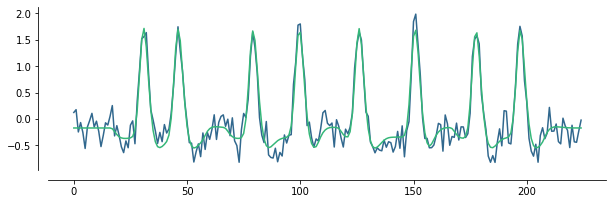

In [20]:
glm.plot_array([synth_fmri,new_prediction], xkcd=False, figsize=(10,3))


---
# Size/response curves?

In [21]:
dim_stim = 2
bar_stim = False
center_prfs = True
plot_data = False
plot_curves = True
resp_measure = 'Max (model-based)'
normalize_response = True
confint = True
n_pix = prf_stim.design_matrix.shape[0]

center = np.flip(np.squeeze(np.array(np.where(prf == np.amax(prf))[1:])))
center = [n_pix//2,n_pix//2]
print(f"Center of pRF = {center}")

ss_deg = 2.0 * np.degrees(np.arctan(prf_stim.screen_size_cm /(2.0*prf_stim.screen_distance_cm)))

x = np.linspace(-ss_deg/2, ss_deg/2, n_pix)
dx = prf_stim.design_matrix.shape[0]/len(x)

Center of pRF = [135, 135]


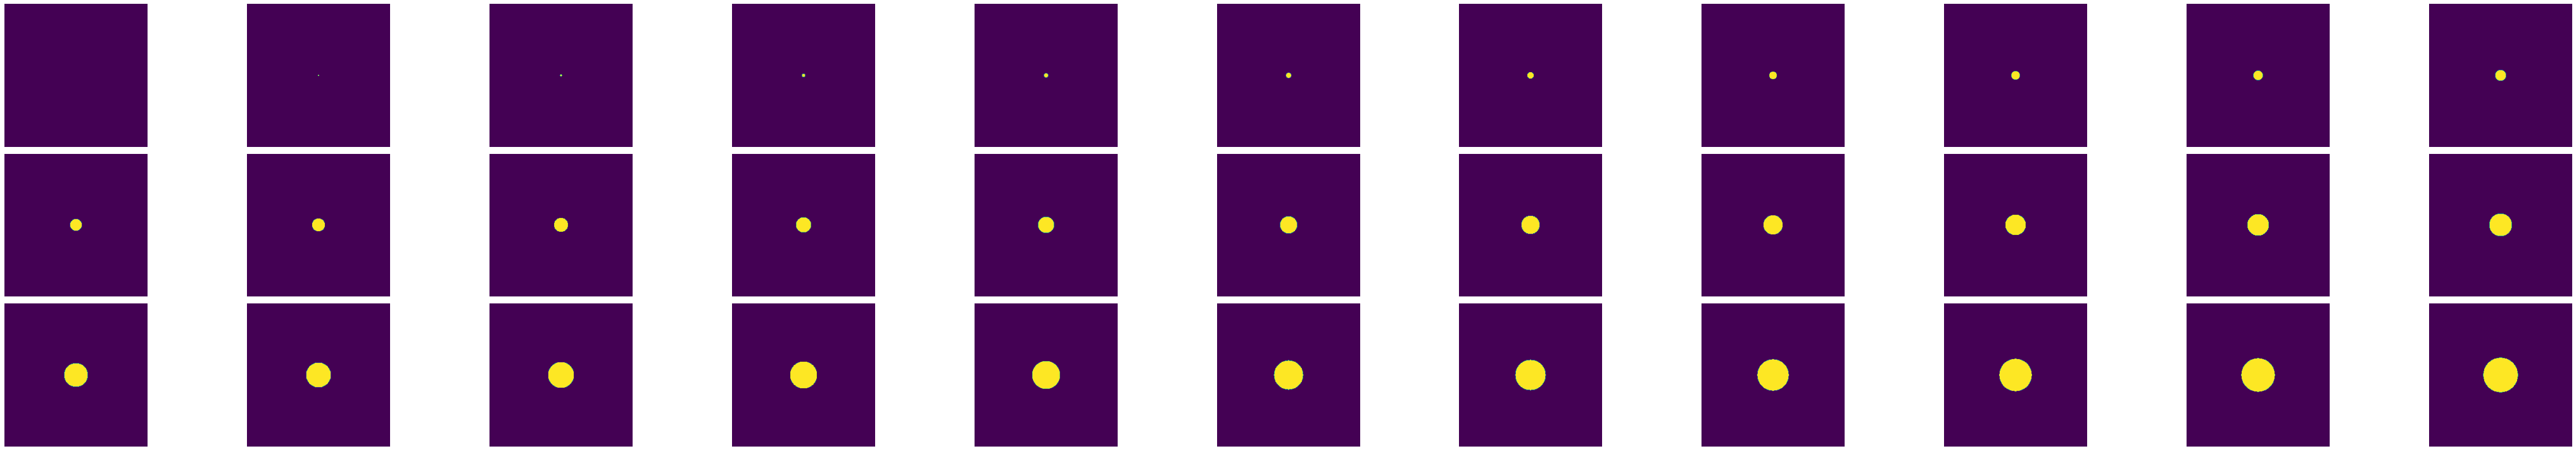

In [22]:
# create filled stimuli
stims_fill, stims_fill_sizes = prf.make_stims(n_pix, prf_stim, factr=4)
prf.plot_stims(stims_fill)

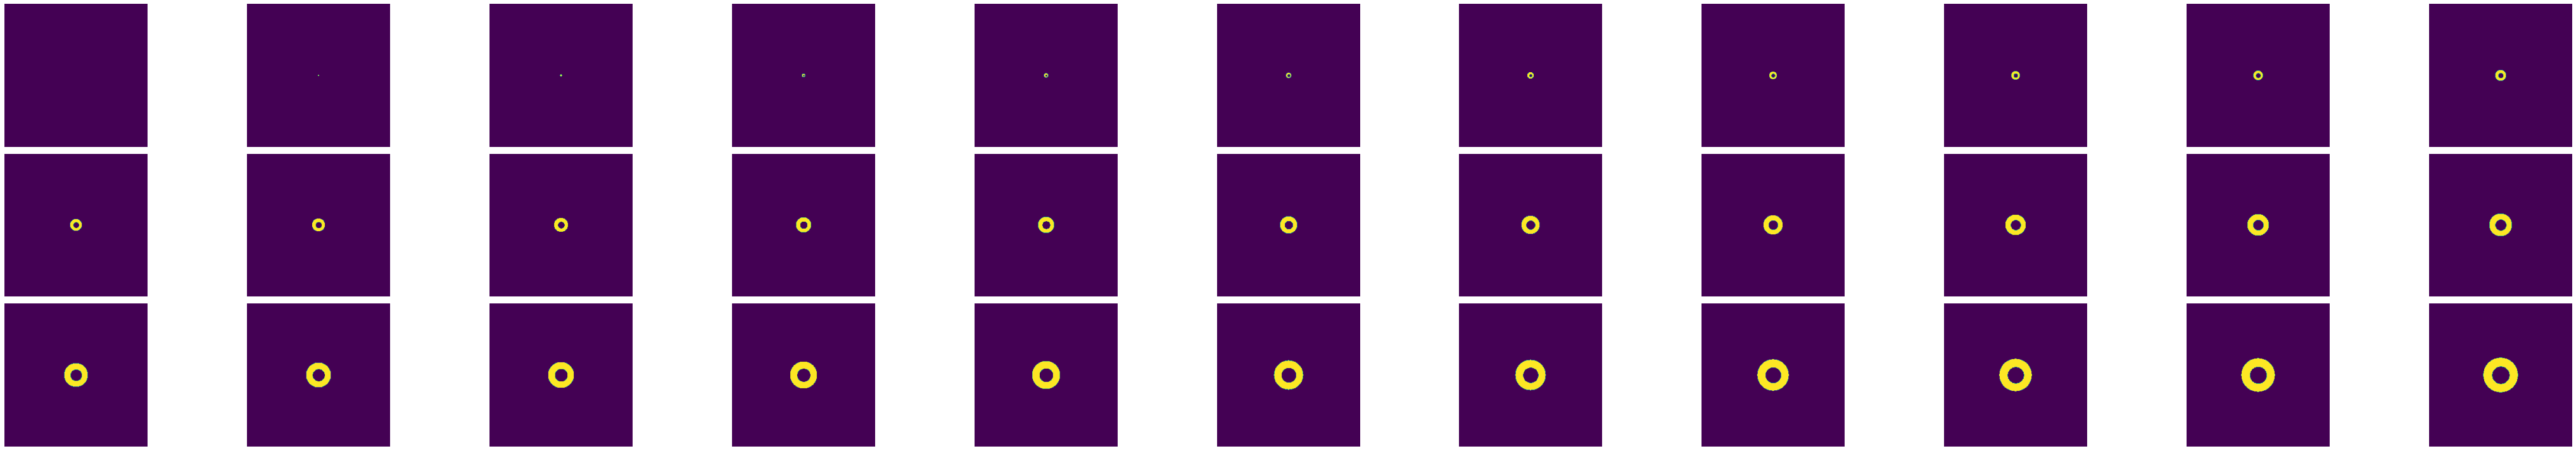

In [23]:
stims_conc, stims_fill_conc = prf.make_stims(n_pix, prf_stim, concentric=True, concentric_size=0.5)
prf.plot_stims(stims_conc)


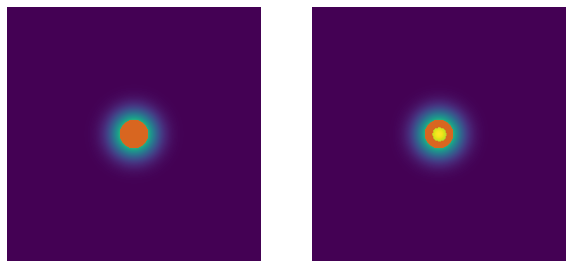

In [24]:
# confirm location of stims
from linescanning.utils import make_binary_cm
fig,axs = plt.subplots(1,2, figsize=(10,10))
cmap = make_binary_cm(216, 102, 32)
axs[0].imshow(np.squeeze(prf_array))
axs[0].imshow(stims_fill[15], cmap=cmap)
axs[0].axis('off')

axs[1].imshow(np.squeeze(prf_array))
axs[1].imshow(stims_conc[15], cmap=cmap)
axs[1].axis('off')

plt.show()


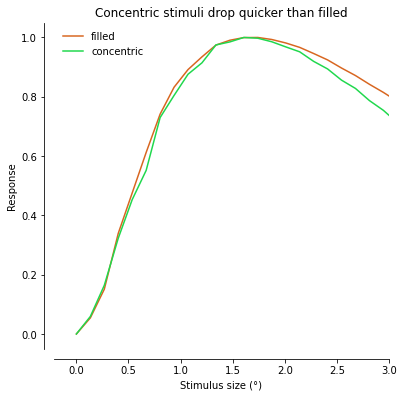

In [26]:
mean_srf_fill = prf.norm_2d_sr_function(A, B, C, D, prf_size, ss, x, x, stims_fill, mu_x=0, mu_y=0)
mean_srf_fill /= mean_srf_fill.max()

mean_srf_conc = prf.norm_2d_sr_function(A, B, C, D, prf_size, ss, x, x, stims_conc, mu_x=0, mu_y=0)
mean_srf_conc /= mean_srf_conc.max()

# with plt.xkcd():
fig = plt.figure(figsize=(6,6))
plt.plot(stims_fill_sizes, mean_srf_fill, color=(216/255, 102/255, 32/255), label='filled')
plt.plot(stims_fill_conc, mean_srf_conc, color=(32/255, 216/255, 77/255), label='concentric')
plt.title("Concentric stimuli drop quicker than filled")
plt.ylabel("Response")
plt.xlabel("Stimulus size (°)")
plt.xlim(right=3)
plt.legend(frameon=False)
sns.despine(offset=10)

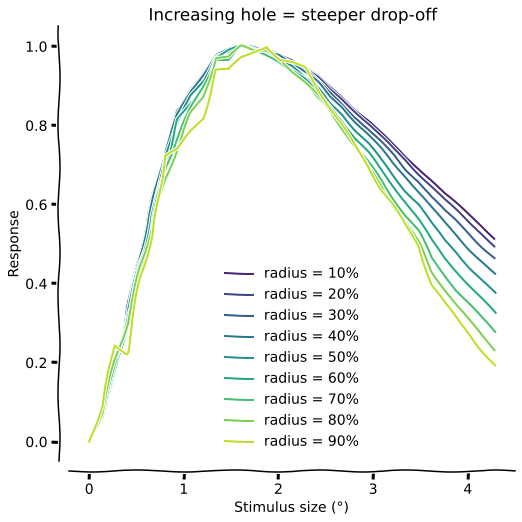

In [27]:
# create concentric stimuli
stim_dict,size_dict,sr_dict = {},{},{}

conc_radii = np.arange(10,100, step=10)
for ix,ii in enumerate(conc_radii):
    stim_dict[ix],size_dict[ix] = prf.make_stims(n_pix, prf_stim, concentric=True, concentric_size=(ii/100))
    sr_dict[ix] = prf.norm_2d_sr_function(A, B, C, D, prf_size, ss, x, x, stim_dict[ix], mu_x=0, mu_y=0)
    sr_dict[ix] /= sr_dict[ix].max()


cols = sns.color_palette('viridis', len(stim_dict))
with plt.xkcd():
    fig = plt.figure(figsize=(8,8))

    for ix,ii in enumerate(conc_radii):
        plt.plot(size_dict[ix], sr_dict[ix], color=cols[ix], label=f'radius = {conc_radii[ix]}%')
        plt.ylabel("Response")
        plt.title("Increasing hole = steeper drop-off")
        plt.xlabel("Stimulus size (°)")
        plt.legend(frameon=False)
        # plt.xlim(right=3)
        sns.despine(offset=10)


size = 4.286940392820204


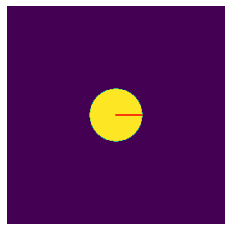

In [28]:
print(f"size = {stims_fill_sizes[-1]}")
rad = prf.radius(stims_fill[-1])
plt.imshow(stims_fill[-1])
start = (270//2)/270
plt.axhline((270//2), xmin=start, xmax=((270//2)+rad)/270, color='r')
plt.axis('off')
plt.show()


In [29]:
diameter = prf.radius(stims_fill[-1])*2

print(f"orig deg                    = {round(stims_fill_sizes[-1],2)}")
print(f"pix2deg with pixel diameter = {round(prf.pix2deg(diameter, prf_stim),2)}")

print(f"orig pix                    = {diameter}")
print(f"deg2pix with visual angle   = {prf.deg2pix(stims_fill_sizes[-1], prf_stim)}")


orig deg                    = 4.29
pix2deg with pixel diameter = 4.29
orig pix                    = 65.0
deg2pix with visual angle   = 65.0


In [25]:
# can we make bars with visual degrees?

prf_object = prf_stim

ss_deg = 2.0 * np.degrees(np.arctan(prf_object.screen_size_cm /(2.0*prf_object.screen_distance_cm)))
x = np.linspace(-ss_deg/2, ss_deg/2, n_pix)

if dim_stim == 1:
    stims = [np.zeros_like(n_pix) for n in range(int(n_pix/4))]
else:
    factr=4
    stims = [np.zeros((n_pix, n_pix)) for n in range(int(n_pix/(2*factr)))]
    stim_sizes=[]

for pp, stim in enumerate(stims):
    
    if dim_stim == 1:
        #2d rectangle or 1d
        stim[int(stim.shape[0]/2)-pp:int(stim.shape[0]/2)+pp] = 1
    else:
        #2d circle
        xx,yy = np.meshgrid(x,x)
        stim[((xx**2+yy**2)**0.5)<(x.max()*pp/(len(stims)*factr))] = 1
        stim_sizes.append(2*(x.max()*pp/(len(stims)*factr)))

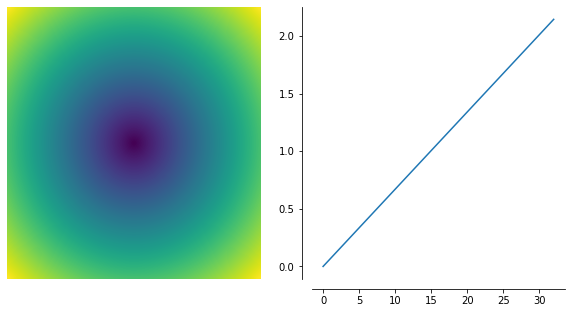

In [26]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
grid = (xx**2+yy**2)**0.5

axs[0].imshow(grid, aspect="auto")
axs[0].axis('off')

axs[1].plot(x.max()*range(33)/(len(stims)*factr))

sns.despine(offset=10)
plt.show()


In [27]:
max_ix = int(np.where(mean_srf_fill == np.amax(mean_srf_fill))[0])
max_deg = stims_fill_sizes[max_ix]
max_pix = int(prf.deg2pix(max_deg, prf_stim))

print(f"max visual degree = {max_deg}")
print(f"max visual pixels = {max_pix}")


max visual degree = 1.741569534583208
max visual pixels = 26


---
# Create library of stimuli

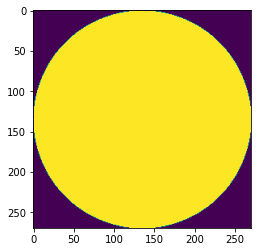

In [28]:
aperture = prf.create_circular_mask(n_pix,n_pix)
plt.imshow(aperture)

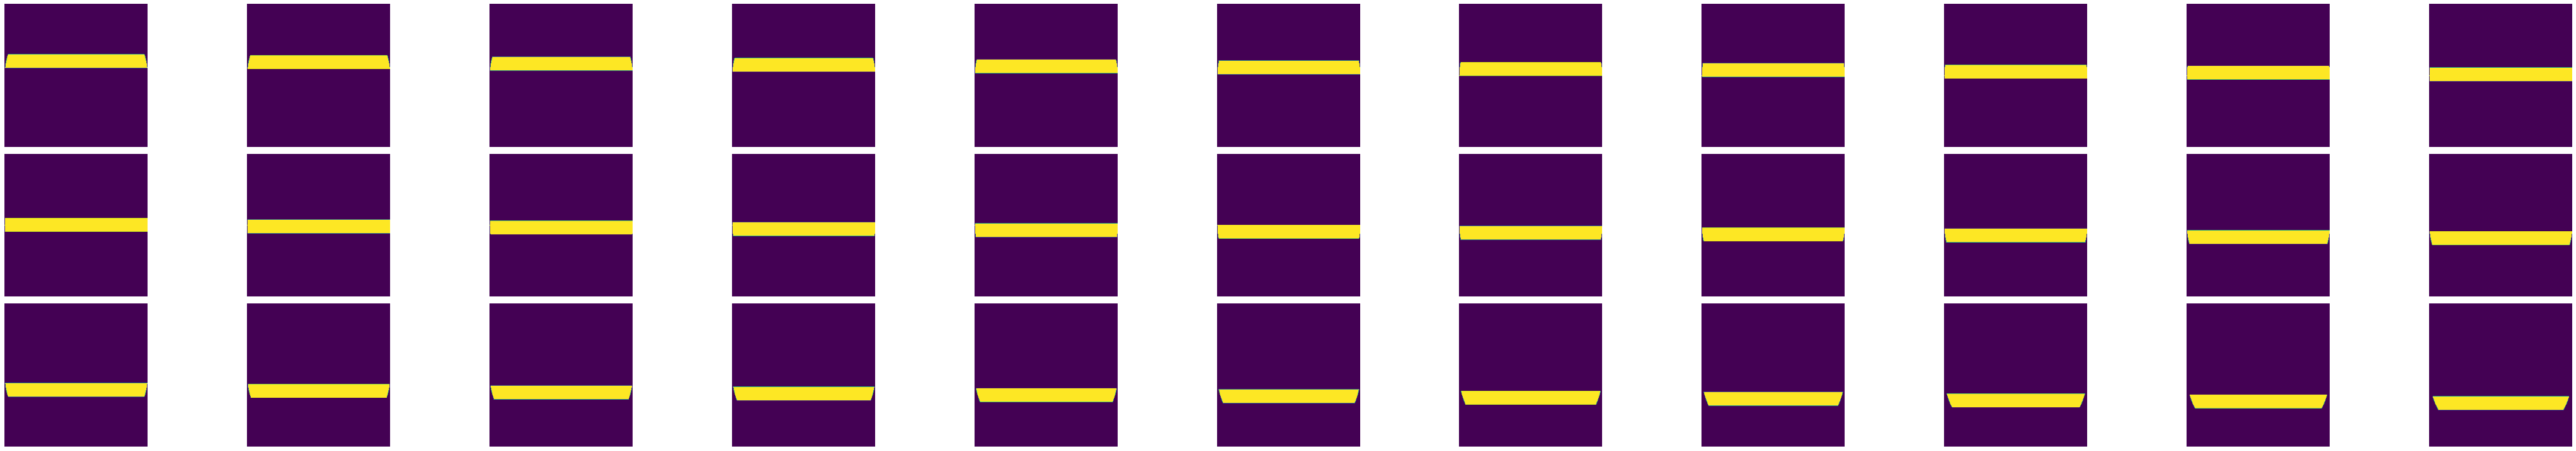

In [29]:
beam_locations = np.linspace(n_pix//2-40,n_pix//2+40,num=33).astype(int)

horizontal = [np.zeros((n_pix, n_pix)) for n in beam_locations]

for pp, stim in enumerate(horizontal):

    total = beam_locations[pp]+max_pix

    if total <= n_pix:
        stim[beam_locations[pp]:beam_locations[pp]+max_pix,:] = 1
    else:
        remains = total - n_pix
        stim[beam_locations[pp]:(beam_locations[pp]+max_pix)-remains,:] = 1

    stim[~aperture.astype(bool)] = 0

prf.plot_stims(horizontal)   


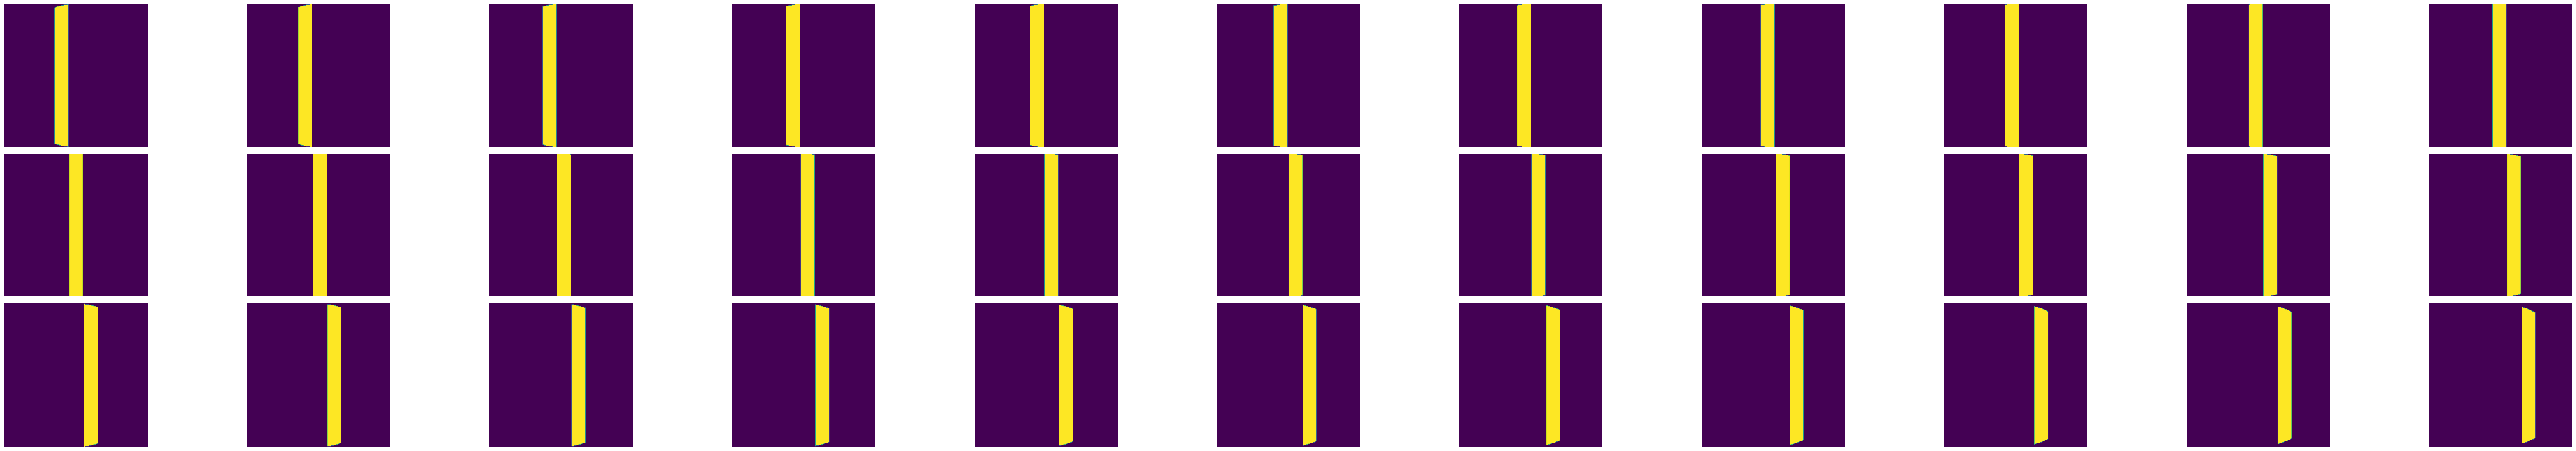

In [30]:
vertical = [np.zeros((n_pix, n_pix)) for n in beam_locations]

for pp, stim in enumerate(vertical):

    total = beam_locations[pp]+max_pix

    if total <= n_pix:
        stim[:,beam_locations[pp]:beam_locations[pp]+max_pix] = 1
    else:
        remains = total - n_pix
        stim[:,beam_locations[pp]:(beam_locations[pp]+max_pix)-remains] = 1

    stim[~aperture.astype(bool)] = 0

prf.plot_stims(vertical)   

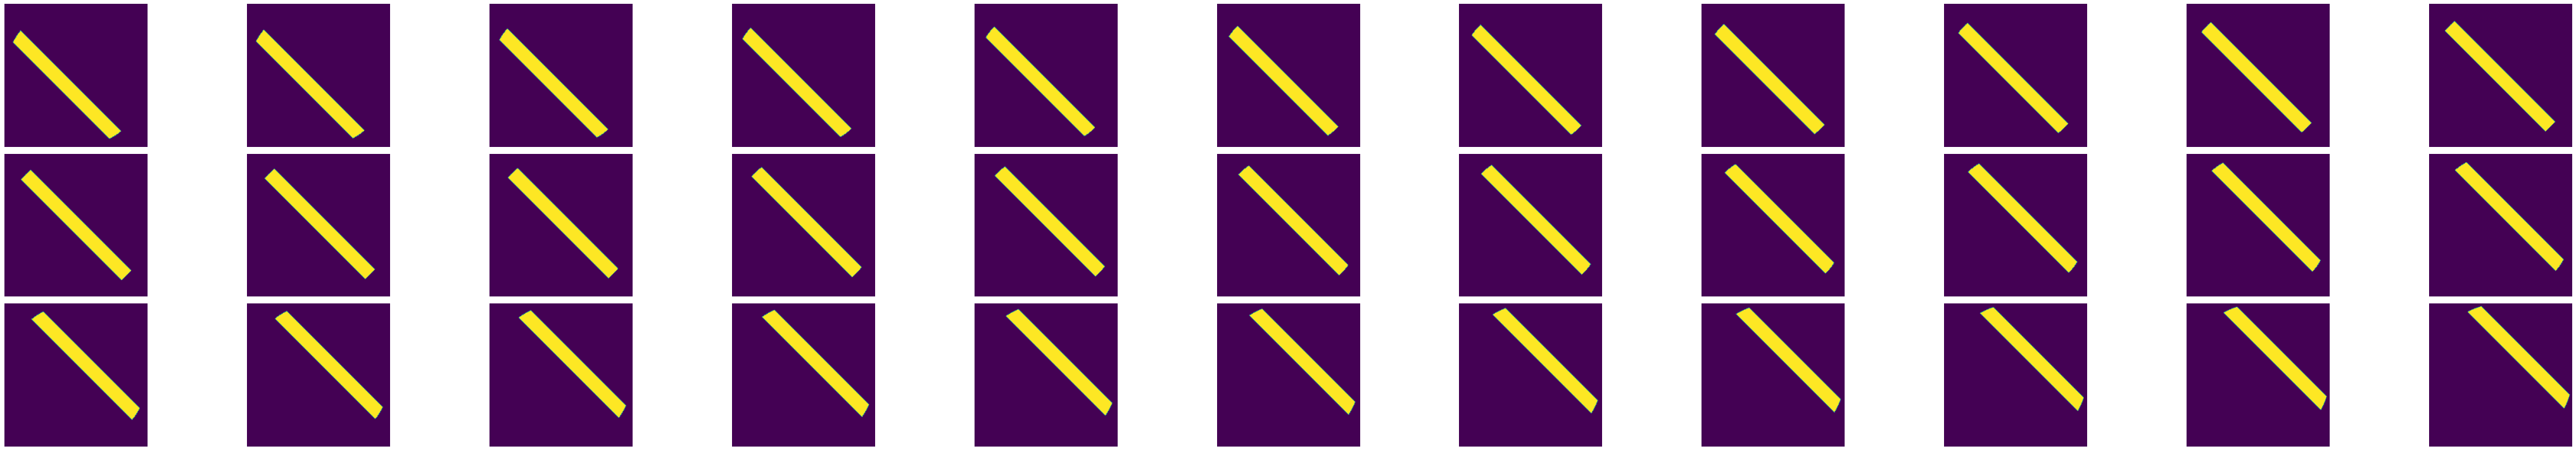

In [31]:
from scipy.ndimage import rotate

rot45 = []

for pp, stim in enumerate(vertical):

    stim_rot = rotate(stim, 45, reshape=False, order=1)
    rot45.append(stim_rot)
    # stim[~aperture.astype(bool)] = 0

prf.plot_stims(rot45)   


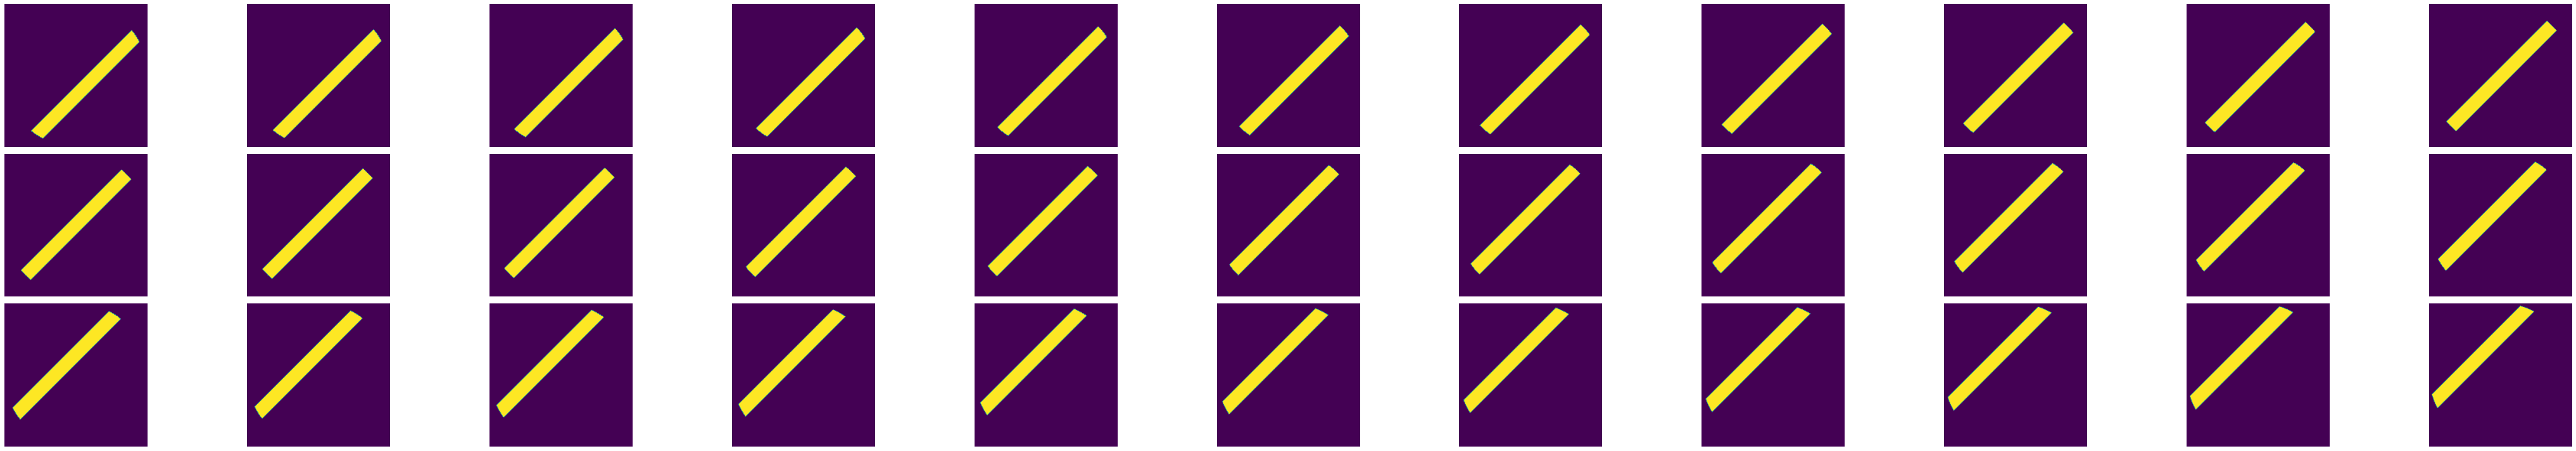

In [32]:
rot135 = []

for pp, stim in enumerate(vertical):

    stim_rot = rotate(stim, 135, reshape=False, order=1)
    rot135.append(stim_rot)
    # stim[~aperture.astype(bool)] = 0

prf.plot_stims(rot135)


In [33]:
# import random

# chunk_size = int(round((225-15-8)/8,0))
# chunk_nr = int(round((225-15-8)/chunk_size,0))

# baseline = np.dstack([np.zeros_like(stims[0]) for i in range(15)])
# isi_chunk = np.dstack([np.zeros_like(stims[0]) for i in range(chunk_size)])

# chunk_list = []
# for ii in range(chunk_nr):
#     add_chunk = np.dstack((test_stims[..., ii][..., np.newaxis], isi_chunk))
#     # print(add_chunk.shape)
#     chunk_list.append(add_chunk)
#     random.shuffle(chunk_list)

# chunk_list.insert(0,baseline)
# design = np.concatenate(chunk_list, axis=-1)
# design = np.dstack((design, np.dstack([np.zeros_like(stims[0]) for i in range(225-design.shape[-1])])))
# print(design.shape)



In [34]:
use_settings = {'hori': [0, 18],
                'vert': [4, 25],
                'rot_45': [4, 18],
                'rot_135': [0, 5]}

np.sum([use_settings[ii][0] for ii in use_settings.keys()])
# pd.DataFrame(use_settings, index=['nr_stims', 'idx_lib'])

8

In [35]:
# # useful plotting tips:
# # https://dfrieds.com/data-visualizations/style-plots-python-matplotlib.html

# # confirm location of stims
# from linescanning.utils import make_binary_cm
# fig, axs = plt.subplots(1, 4, figsize=(20, 15))
# cmap = make_binary_cm(216, 102, 32)
# humorfont = {'fontname': 'Humor Sans'}

# prf_actual = np.squeeze(prf.make_prf(prf_stim, size=params[2], mu_x=params[0], mu_y=params[1]),axis=0)
# alpha = 0.6

# cmap_grey = make_binary_cm(230,230,230)
# cmap_blue = make_binary_cm(8,178,240)

# plt.suptitle("example stimuli in 4 directions", y=0.65, fontsize=20, **humorfont)

# for ix,ii in enumerate(use_settings.keys()):

#     axs[ix].axvline(0, color='k', linestyle='dashed', lw=0.5)
#     axs[ix].axhline(0, color='k', linestyle='dashed', lw=0.5)
#     axs[ix].imshow(prf_actual, extent=vf_extent+vf_extent, cmap=cmap_blue)
#     axs[ix].imshow(lib[ii][use_settings[ii][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
#     axs[ix].axis('off')

# plt.show()


In [36]:
lib = {'hori': horizontal,
       'vert': vertical,
       'rot_45': rot45,
       'rot_135': rot135,
       'filled': stims_fill,
       'conc': stims_conc}


def select_stims(settings_dict, frames=225, baseline_frames=15, randomize=False, shuffle=True, verbose=False):

    """
select_stims

Function to create a fictitious design matrix based on the 'lib'-variable containing a library of 4 different types of
bar stimuli: 'hori' (horizontal), 'vert' (vertical) 'rot_45' (horizontal bars rotated 45 degrees counterclockwise), 
and 'rot_135' (horizontal bars rotated 135 degrees counterclockwise). Using a 'settings'-dictionary, you can specify
how many and which of each of these stimuli you want. 

Args:
    settings_dict          : dict
                            dictionary containing the number of stimuli and index of stimuli (as per the library) that
                            you would like to include. An example is:

                            use_settings = {'hori': [0, 18],
                                            'vert': [4, 25],
                                            'rot_45': [4, 18],
                                            'rot_135': [0, 5]}

                            this selects 0 horizontal stimuli, 4x the 25th vertical stimulus in 'lib', 4x the 18th sti-
                            mulus of the 45 degree rotated stimuli, and 0 of the 135 degree rotated stimuli.

    frames                  : int (default = 225)
                            number of frames your design matrix should have. Should be the same as your functional data
                            in terms of TR!

    baseline_frames         : int (default = 15)
                            number of baseline frames before stimulus presentation begins. Only needs to be specified
                            if 'randomize' is set to False. 
    
    randomize               : bool (default = False)
                            boolean whether you want to completely randomize your experiment or not. Generally you'll 
                            want to set this to false, to create a regular intervals between stimuli. 

    shuffle                 : bool (default = True )
                            if randomize is turned off, we can still shuffle the order of the stimulus presentations.
                            This you can do by setting shuffle to True
    
    verbose                 : bool (default = False)
                            Set to True if you want some messages along the way

Returns:
    design/stims            : np.ndarray
                            <n_pix,n_pix,frames> numpy array representing your design

    """
    
    import numpy as np
    import random

    try:
        hori        = settings_dict['hori']
        vert        = settings_dict['vert']
        rot_45      = settings_dict['rot_45']
        rot_135     = settings_dict['rot_135']
        filled      = settings_dict['filled']
        conc        = settings_dict['conc']
    except:
        print(select_stims.__doc__)
        raise Exception("Could not extract relevant information; check the doc for an example of settings_dict")

    total_stims = np.sum([settings_dict[ii][0] for ii in settings_dict.keys()])

    if verbose:
        print(f"Creating design with {total_stims} stimuli and length of {frames}")

    stims = []

    # get stims for each orientation
    for ori in settings_dict.keys():

        if verbose:
            print(f"Using {settings_dict[ori][0]} stimuli of '{ori}'-orientation")

        if settings_dict[ori][0] != 0:
            if not settings_dict[ori][1]:
                idc = np.random.choice(33,1)[0]
            else:
                idc = settings_dict[ori][1]

        for ii in range(settings_dict[ori][0]):
            stims.append(lib[ori][idc])
            
    # fill to end of frames
    nr_stims = len(stims)
    fill_stims = frames - nr_stims

    # completely randomize trials and baseline
    if randomize:
        for ii in range(fill_stims):
            stims.append(np.zeros_like(stims[0]))

        stims = np.array(stims)

        idc = np.arange(0,frames)
        np.random.shuffle(idc)
        stims = stims[idc,:,:]

        return stims.T

    # make regular intervals between stimuli
    else:
        # fetch how many frames do not have stimulus
        frames_no_stim = fill_stims - baseline_frames

        # fetch how many frames should be presented between each stimulus
        chunk_size = int(round((frames_no_stim)/total_stims, 0))

        # get the number of chunks (i think this is redundant, as it's the same as the number of stimuli..)
        chunk_nr = int(round((frames_no_stim)/chunk_size, 0))

        # create (n_pix,n_pix,baseline_frames) array
        baseline = np.dstack([np.zeros_like(stims[0]) for i in range(baseline_frames)])

        # create (n_pix,n_pix,chunk_size) array
        isi_chunk = np.dstack([np.zeros_like(stims[0]) for i in range(chunk_size)])

        # initialize list
        chunk_list = []

        # loop through stimuli
        for ii in range(chunk_nr):

            # create chunk with stimulus + isi
            add_chunk = np.dstack((stims[ii][..., np.newaxis], isi_chunk))
            chunk_list.append(add_chunk)

            # shuffle the order of stimulus presentations
            if shuffle:
                random.shuffle(chunk_list)
        
        # add baseline at the beginning
        chunk_list.insert(0,baseline)

        # concatenate into a numpy array
        design = np.concatenate(chunk_list, axis=-1)

        # add or cut frames at the end to meet the nr of frames
        if design.shape[-1] > frames:
            design = design[:,:,:frames]
        elif design.shape[-1] < frames:
            design = np.dstack((design, np.dstack([np.zeros_like(stims[0]) for i in range(frames-design.shape[-1])])))

        if verbose:
            print(f"design has shape: {design.shape}")
            print("done")
        
        return design,total_stims


In [37]:
# Fully centered stimuli (8 stims)
use_settings = {'hori': [0, 18],
                'vert': [4, 25],
                'rot_45': [4, 18],
                'rot_135': [0, 5],
                'filled': [0, 0],
                'conc': [0, 0]}

center_design_full,n_stims = select_stims(settings_dict=use_settings)            


# Fully centered stimuli (4 stims)
use_settings = {'hori': [0, 18],
                'vert': [2, 25],
                'rot_45': [2, 18],
                'rot_135': [0, 5],
                'filled': [0, 0],
                'conc': [0, 0]}

center_design_half,n_stims = select_stims(settings_dict=use_settings)

# Half center/half surround
use_settings = {'hori': [0, 18],
                'vert': [4, 14],
                'rot_45': [4, 18],
                'rot_135': [0, 5],
                'filled': [0, 0],
                'conc': [0, 0]}

center_surround,n_stims = select_stims(settings_dict=use_settings)

# full surround
use_settings = {'hori': [0, 18],
                'vert': [4, 14],
                'rot_45': [4, 28],
                'rot_135': [0, 5],
                'filled': [0, 0],
                'conc': [0, 0]}

surround,n_stims = select_stims(settings_dict=use_settings)


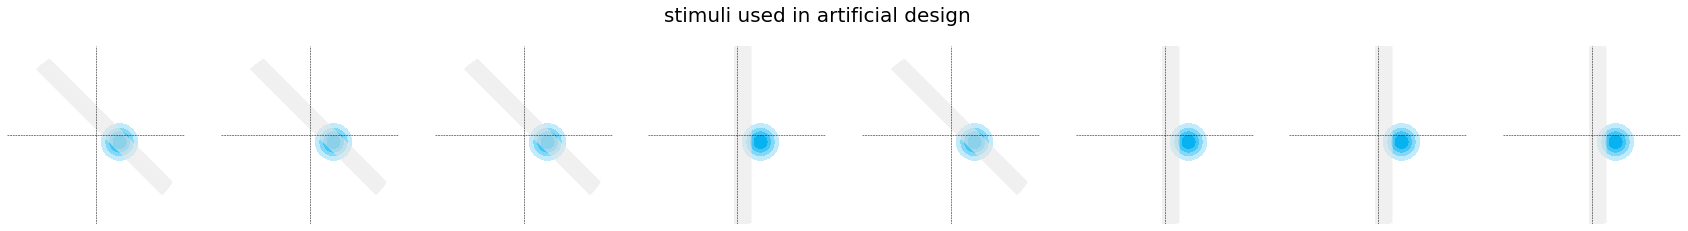

In [38]:
# which design to plot
design_to_use = center_surround

total_stims = n_stims

f, sub = plt.subplots(1, total_stims, figsize=(30, 10))  # , figsize=(25,10))
humorfont = {'fontname': 'Humor Sans'}
prf_actual = np.squeeze(prf.make_prf(prf_stim, size=params[2], mu_x=params[0], mu_y=params[1]),axis=0)
cmap_grey = make_binary_cm(230,230,230)
cmap_blue = make_binary_cm(8,178,240)

plt.suptitle("stimuli used in artificial design", y=0.68, fontsize=20, **humorfont)

count = 0
for ii in range(design_to_use.shape[-1]):

    max_val = np.amax(design_to_use[..., ii])
    if max_val > 0:
        sub[count].axvline(0, color='k', linestyle='dashed', lw=0.5)
        sub[count].axhline(0, color='k', linestyle='dashed', lw=0.5)
        sub[count].imshow(prf_actual, extent=vf_extent+vf_extent, cmap=cmap_blue, aspect=1)
        sub[count].imshow(design_to_use[..., ii], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=0.6, aspect=1)
        sub[count].axis('off')

        count += 1


In [39]:
# f, sub = plt.subplots(1, 30, figsize=(40, 6))
# for x in range(15, 45):
#     sub[x-15].imshow(test_stims[...,x])
#     sub[x-15].axis('off')

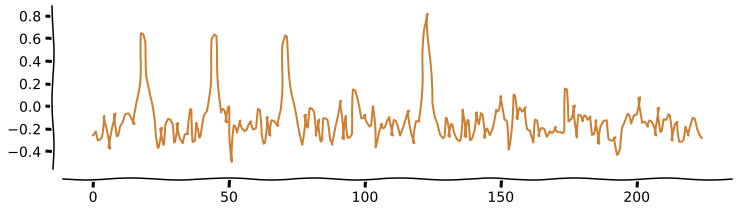

In [40]:
prf_stim_simu = stimulus.PRFStimulus2D(screen_size_cm=70, screen_distance_cm=225, design_matrix=design_to_use,TR=1.5)

# define model
gg_simu = model.Norm_Iso2DGaussianModel(stimulus=prf_stim_simu,
                                        filter_predictions=False,
                                        filter_type='sg',
                                        filter_params={'window_length': 300, 'polyorder': 1})

# get the prediction of the pRF timecourse given this stimulus package
x_simu = np.squeeze(gg_simu.return_prediction(*params).T)

# add noise to data
noise = np.random.normal(0, 0.1, x_simu.shape[0])
simu_fmri = x_simu+noise

glm.plot_array(simu_fmri, xkcd=True)


In [41]:
# Fit data again
gf_simu = fit.Norm_Iso2DGaussianFitter(gg_simu, simu_fmri[..., np.newaxis].T)
old_params = np.array((*new_params[:3], new_params[-1]))[np.newaxis, ...]

#################################################################################################################
# # Uncomment to rerun gridsearch
# # ~250s
# gf_simu.grid_fit(surround_amplitude_grid, 
#                  surround_size_grid, 
#                  neural_baseline_grid,
#                  surround_baseline_grid, 
#                  gaussian_params=old_params, 
#                  n_batches=1)

# new_params_simu = gf_simu.gridsearch_params[0]
#################################################################################################################


In [42]:
print(f"params = {new_params_simu}")
new_prediction_simu = gg_simu.return_prediction(*new_params_simu[:-1]).T

X_prf_simu      = new_params_simu[0]
Y_prf_simu      = new_params_simu[1]
A_simu          = new_params_simu[3]
B_simu          = new_params_simu[-3]/new_params_simu[3]
C_simu          = new_params_simu[5]
D_simu          = new_params_simu[-2]
ss_simu         = new_params_simu[6]
r2_simu         = new_params_simu[-1]
prf_size_simu   = new_params_simu[2]
norm_simu       = ss_simu/A_simu

# print('\n--------------------------------------------------------------------------------------------------')
# print(f'X                       = {round(X_prf_simu,2)} \t\t(was {round(X_prf,2)})')
# print(f'Y                       = {round(Y_prf_simu,2)} \t(was {round(Y_prf,2)})')
# print(f'A (prf amplitude/beta)  = {round(A_simu,2)} \t\t(was {round(A,2)})')
# print(f'B (neural baseline)     = {round(B_simu,2)} \t\t(was {round(B,2)})')
# print(f'C (surround amplitude)  = {round(C_simu,2)} \t\t(was {round(C,2)})')
# print(f'D (surround baseline)   = {round(D_simu,2)} \t\t(was {round(D,2)})')
# print(f'R2                      = {round(r2_simu,2)} \t\t(was {round(r2,2)})')
# print(f'Surround size           = {round(ss_simu,2)} \t\t(was {round(ss,2)})')
# print(f'pRF size                = {round(prf_size_simu,2)} \t(was {round(prf_size,2)})')
# print(f'Size ratio (phi)        = {round(norm_simu,2)} \t\t(was {round(norm,2)})')

output = {'new': [X_prf_simu, Y_prf_simu, A_simu, B_simu, C_simu, D_simu, ss_simu, r2_simu, prf_size_simu, norm_simu],
          'old': [X_prf, Y_prf, A, B, C, D, ss, r2, prf_size, norm]}

output_df = pd.DataFrame(output, index=['x', 'y', 'A (prf ampl)', 'B (neural base)', 'C (surround ampl)', 'D (surround base)', 'surround size', 'r2', 'prf size', 'size ratio (phi)'])
print(output_df)

glm.plot_array([simu_fmri, new_prediction_simu], xkcd=True)

NameError: name 'new_params_simu' is not defined

---
# Deconvolve simulated experiment

- size/response curve experiment
- 'standard' pRF-experiment; move bar every TR

In [43]:
lib = {'hori': horizontal,
       'vert': vertical,
       'rot_45': rot45,
       'rot_135': rot135,
       'filled': stims_fill,
       'conc': stims_conc}


def get_onset_idx(design):

    idx = []
    for ii in range(design.shape[-1]):

        if np.amax(design[..., ii]) != 0:
            idx.append(ii)

    idx = np.array(idx)

    return idx

def select_stims(settings_dict, frames=225, baseline_frames=15, randomize=False, shuffle=True, verbose=False, TR=1.5, return_onsets=False, settings_fn=None):

    """
select_stims

Function to create a fictitious design matrix based on the 'lib'-variable containing a library of 4 different types of
bar stimuli: 'hori' (horizontal), 'vert' (vertical) 'rot_45' (horizontal bars rotated 45 degrees counterclockwise), 
and 'rot_135' (horizontal bars rotated 135 degrees counterclockwise). Using a 'settings'-dictionary, you can specify
how many and which of each of these stimuli you want. 

Args:
    settings_dict          : dict
                            dictionary containing the number of stimuli and index of stimuli (as per the library) that
                            you would like to include. An example is:

                            use_settings = {'hori': [0, 18],
                                            'vert': [4, 25],
                                            'rot_45': [4, 18],
                                            'rot_135': [0, 5]}

                            this selects 0 horizontal stimuli, 4x the 25th vertical stimulus in 'lib', 4x the 18th sti-
                            mulus of the 45 degree rotated stimuli, and 0 of the 135 degree rotated stimuli.

    frames                  : int (default = 225)
                            number of frames your design matrix should have. Should be the same as your functional data
                            in terms of TR!

    baseline_frames         : int (default = 15)
                            number of baseline frames before stimulus presentation begins. Only needs to be specified
                            if 'randomize' is set to False. 
    
    randomize               : bool (default = False)
                            boolean whether you want to completely randomize your experiment or not. Generally you'll 
                            want to set this to false, to create a regular intervals between stimuli. 

    shuffle                 : bool (default = True )
                            if randomize is turned off, we can still shuffle the order of the stimulus presentations.
                            This you can do by setting shuffle to True
    
    verbose                 : bool (default = False)
                            Set to True if you want some messages along the way

Returns:
    design/stims            : np.ndarray
                            <n_pix,n_pix,frames> numpy array representing your design

    """
    
    import numpy as np
    import random

    onset_idx = None
    index_shuf = None

    try:
        hori        = settings_dict['hori']
        vert        = settings_dict['vert']
        rot_45      = settings_dict['rot_45']
        rot_135     = settings_dict['rot_135']
        filled      = settings_dict['filled']
        conc        = settings_dict['conc']
    except:
        print(select_stims.__doc__)
        raise Exception("Could not extract relevant information; check the doc for an example of settings_dict")

    total_stims = np.sum([settings_dict[ii][0] for ii in settings_dict.keys()])  

    if verbose:
        print(f"Creating design with {total_stims} stimuli and length of {frames}")

    stims = []

    # get stims for each orientation
    for ori in settings_dict.keys():

        if verbose:
            print(f" Using {settings_dict[ori][0]} stimuli of '{ori}'-orientation")

        if settings_dict[ori][0] != 0:

            if isinstance(settings_dict[ori][1], np.ndarray) or isinstance(settings_dict[ori][1], list):
                idc_list = settings_dict[ori][1]

                onset_idx = list(np.tile(idc_list, settings_dict[ori][0]))

                for ii in range(settings_dict[ori][0]):
                    stims.append(np.array([lib['filled'][ii] for ii in idc_list]).T)
                
                stims = np.concatenate(stims, axis=-1)
                
            else:
                if not settings_dict[ori][1]:
                    idc = np.random.choice(33,1)[0]
                else:
                    idc = settings_dict[ori][1]

                for ii in range(settings_dict[ori][0]):
                    stims.append(lib[ori][idc])

    if verbose:
        if isinstance(stims, np.ndarray):
            print(f"Stimuli have shape {stims.shape}")
        else:
            print(f"Stimuli have shape {len(stims)}")
                   
    # fill to end of frames
    nr_stims = len(stims)
    fill_stims = frames - nr_stims

    # completely randomize trials and baseline
    if randomize:
        for ii in range(fill_stims):
            stims.append(np.zeros_like(stims[0]))

        stims = np.array(stims)

        idc = np.arange(0,frames)
        np.random.shuffle(idc)
        stims = stims[idc,:,:]

        return stims.T

    # make regular intervals between stimuli
    else:
        if isinstance(stims, np.ndarray):
            ref = stims[...,0]
            actual_stims = stims.shape[-1]
        else:
            ref = stims[0]
            actual_stims = total_stims

        # do ISI calculation as in exptools experiment:
        import yaml

        # from exptools2.core.session._load_settings()
        with open(settings_fn, 'r', encoding='utf8') as f_in:
            settings = yaml.safe_load(f_in)

        total_iti_duration = actual_stims * settings['design'].get('mean_iti_duration')
        min_iti_duration = total_iti_duration - settings['design'].get('total_iti_duration_leeway'), 
        max_iti_duration = total_iti_duration + settings['design'].get('total_iti_duration_leeway')

        def return_itis(mean_duration, minimal_duration, maximal_duration, n_trials):
            itis = np.random.exponential(scale=mean_duration-minimal_duration, size=n_trials)
            itis += minimal_duration
            itis[itis>maximal_duration] = maximal_duration
            return itis

        nits = 0
        itis = return_itis(
            mean_duration=settings['design'].get('mean_iti_duration'),
            minimal_duration=settings['design'].get('minimal_iti_duration'),
            maximal_duration=settings['design'].get('maximal_iti_duration'),
            n_trials=actual_stims)
        while (itis.sum() < min_iti_duration) | (itis.sum() > max_iti_duration):
            itis = return_itis(
                mean_duration=settings['design'].get('mean_iti_duration'),
                minimal_duration=settings['design'].get('minimal_iti_duration'),
                maximal_duration=settings['design'].get('maximal_iti_duration'),
                n_trials=actual_stims)
            nits += 1

        if verbose:
            print(f'ITIs created with total ITI duration of {itis.sum()} after {nits} iterations')

        # fetch new nr of frames based on ITIs
        frames = int(itis.sum()/TR)

        if verbose:
            print(f"New nr of frames = {frames} based on ITIs")

        # new nr of frames to fill
        fill_stim = frames - actual_stims

        # fetch how many frames do not have stimulus
        frames_no_stim = fill_stims - baseline_frames

        # fetch how many frames should be presented between each stimulus
        chunk_size = int(round((frames_no_stim)/actual_stims, 0))

        # create (n_pix,n_pix,baseline_frames) array
        baseline = np.dstack([np.zeros_like(ref) for i in range(baseline_frames)])

        # initialize list
        chunk_list = []

        # loop through stimuli
        for ii in np.arange(0,actual_stims):
            
            if isinstance(stims, np.ndarray):
                stim_array = stims[...,ii]
            else:
                stim_array = stims[ii]

            # create (n_pix,n_pix,chunk_size) array
            isi_chunk = np.dstack([np.zeros_like(ref) for i in range(int(itis[ii]/TR))])

            # create chunk with stimulus + isi
            add_chunk = np.dstack((stim_array[..., np.newaxis], isi_chunk))

            # if verbose:
            #     print(f" Added chunk nr {ii} with shape: {add_chunk.shape}")

            chunk_list.append(add_chunk)

        # shuffle the order of stimulus presentations
        if shuffle:
            
            if onset_idx:

                # I do this so we can keep track of which stimulus in the list was presented
                chunk_list_shuff = []
                stim_shuff = []
                index_shuf = np.arange(0,len(onset_idx))
                random.shuffle(index_shuf)

                for i in index_shuf:
                    chunk_list_shuff.append(chunk_list[i])
                    stim_shuff.append(onset_idx[i])

            else:
                random.shuffle(chunk_list)
                chunk_list_shuff = chunk_list

        # add baseline at the beginning
        chunk_list_shuff.insert(0,baseline)

        # concatenate into a numpy array
        design = np.concatenate(chunk_list_shuff, axis=-1)

        # if verbose:
        #     print(f"Current design shape = {design.shape}")

        # # add or cut frames at the end to meet the nr of frames
        # if design.shape[-1] > frames:
        #     if verbose:
        #         print(f"Removing {design.shape[-1]-frames} frames")
            
        #     design = design[:,:,:frames]
        # elif design.shape[-1] < frames:
        #     if verbose:
        #         print(f"Adding {frames-design.shape[-1]} frames")
        #     design = np.dstack((design, np.dstack([np.zeros_like(ref) for i in range(frames-design.shape[-1])])))

        if verbose:
            print(f"Design has shape: {design.shape}")
        
        if return_onsets:
            # # create onset df
            # try:
            if verbose:
                print("Creating onset dataframe")

            onset_frames = get_onset_idx(design)
            onset_times = onset_frames*TR

            onset_dict = {'onset': onset_times, 
                          'event_type': stim_shuff}

            onset_df = pd.DataFrame(onset_dict)

            if verbose:
                print("Done")
                
            return design, onset_df

            # except:
            #     if verbose:
            #         print("Not returning onset dataframe")

                    
        else:

            if verbose:
                print("Done")

            return design


In [48]:
import pickle

pkl_file = opj(os.path.dirname(fig_dir), 'stimulus_library.pkl')
with open(pkl_file, 'wb') as handle:
    pickle.dump(lib, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
lower_dva, upper_dva = utils.find_nearest(stims_fill_sizes,0.2)[0],utils.find_nearest(stims_fill_sizes,4)[0]

n_stims_select = 7

print(lower_dva,upper_dva)
idc_list = list(np.linspace(lower_dva,upper_dva,num=n_stims_select).astype(int))
idc_list

1 30


[1, 5, 10, 15, 20, 25, 30]

In [108]:
# Half center/half surround
use_settings = {'hori': [0, 18],
                'vert': [0, 14],
                'rot_45': [0, 18],
                'rot_135': [0, 5],
                'filled': [10, idc_list],
                'conc': [0, 0]}

settings_fn = opj(os.path.dirname(glm.__file__), 'experiments', 'gouws', 'settings.yml')

size_response,onset_df = select_stims(settings_dict=use_settings, verbose=True, frames=5700, return_onsets=True, TR=0.105, settings_fn=settings_fn)

# convert index in stims_fill_sizes to degree-of-visual-angle (dva)
onset_df['event_type'] = [round(stims_fill_sizes[ii],2) for ii in onset_df['event_type'].values]

Creating design with 10 stimuli and length of 5700
 Using 0 stimuli of 'hori'-orientation
 Using 0 stimuli of 'vert'-orientation
 Using 0 stimuli of 'rot_45'-orientation
 Using 0 stimuli of 'rot_135'-orientation
 Using 10 stimuli of 'filled'-orientation
 Using 0 stimuli of 'conc'-orientation
Stimuli have shape (270, 270, 70)
ITIs created with total ITI duration of 421.94298377343625 after 34 iterations
New nr of frames = 4018 based on ITIs
Design has shape: (270, 270, 4070)
Creating onset dataframe
Done


In [131]:
dva_conds = onset_df['event_type'].unique()
dva_conds.sort()
print(dva_conds)
print(idc_list)

['0.13' '0.67' '1.34' '2.01' '2.68' '3.35' '4.02']
[1, 5, 10, 15, 20, 25, 30]


In [133]:
%reload_ext autoreload
%autoreload 2

osf = 1000

# get value in S-R curve per dva
ampl = mean_srf_fill[idc_list]
stims_v = glm.make_stimulus_vector(onset_df, scan_length=size_response.shape[-1], osf=osf, type='event', amplitude=ampl)

print(stims_v)

Amplitude for event '0.13' = 0.05
Amplitude for event '0.67' = 0.61
Amplitude for event '1.34' = 0.97
Amplitude for event '2.01' = 0.98
Amplitude for event '2.68' = 0.87
Amplitude for event '3.35' = 0.72
Amplitude for event '4.02' = 0.58
{'0.13': array([0., 0., 0., ..., 0., 0., 0.]), '0.67': array([0., 0., 0., ..., 0., 0., 0.]), '1.34': array([0., 0., 0., ..., 0., 0., 0.]), '2.01': array([0., 0., 0., ..., 0., 0., 0.]), '2.68': array([0., 0., 0., ..., 0., 0., 0.]), '3.35': array([0., 0., 0., ..., 0., 0., 0.]), '4.02': array([0., 0., 0., ..., 0., 0., 0.])}


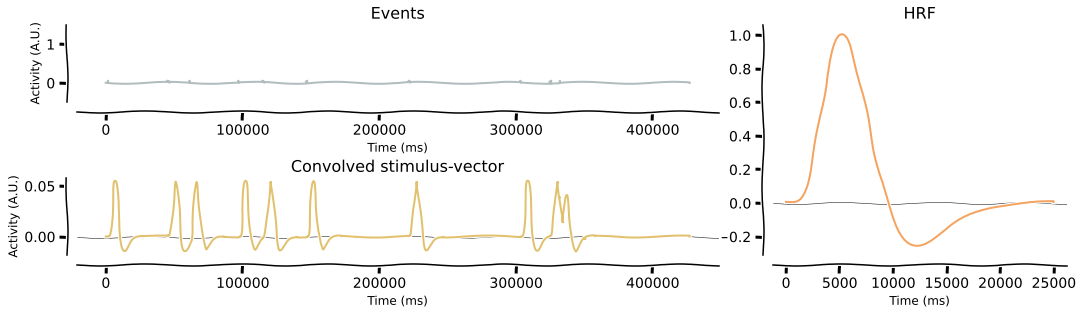

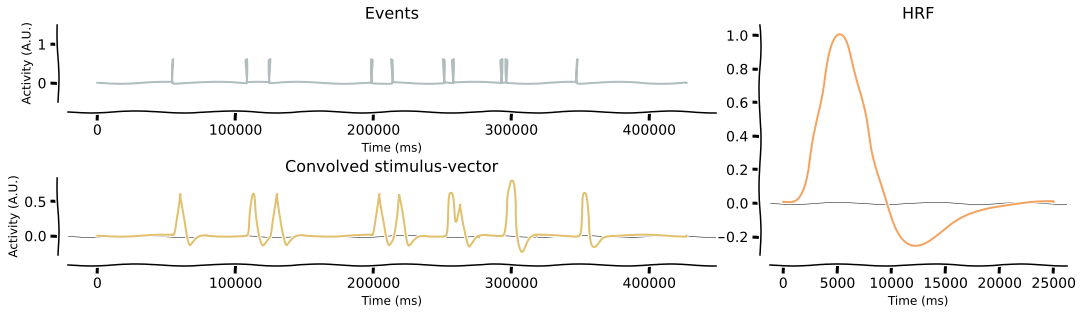

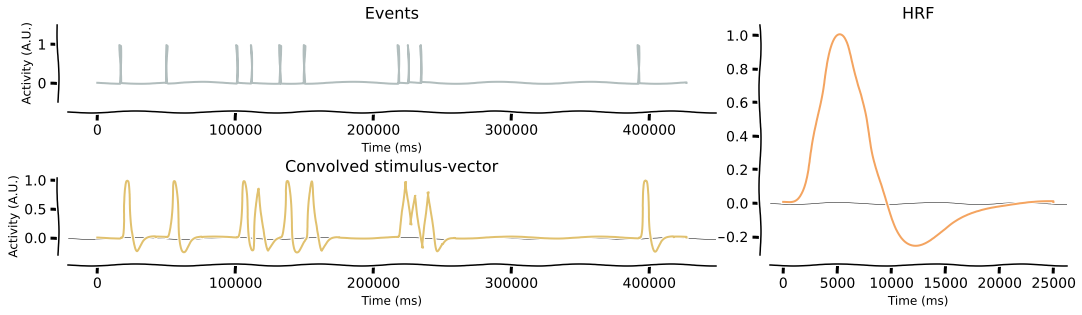

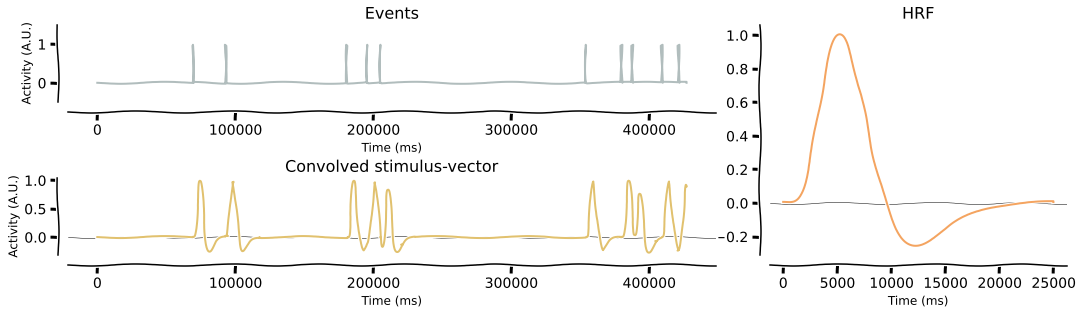

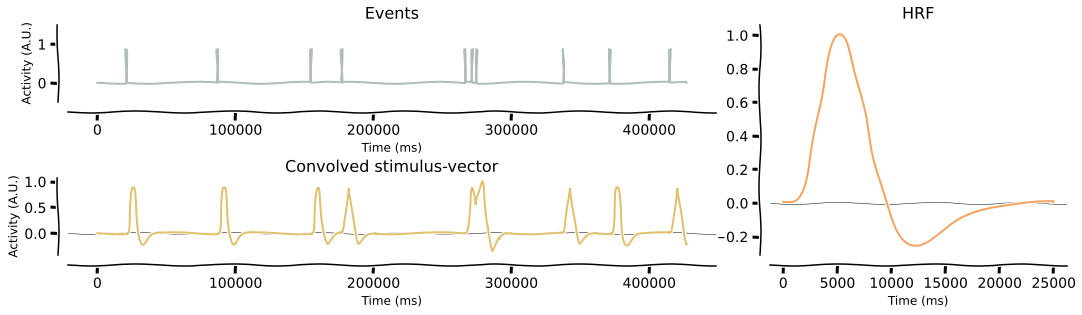

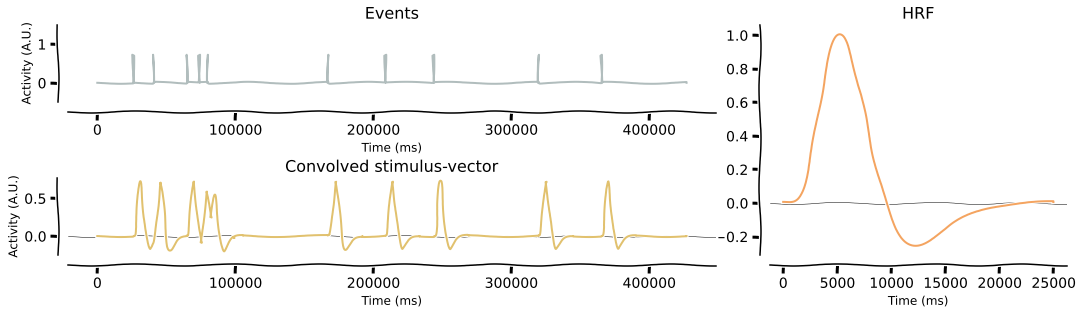

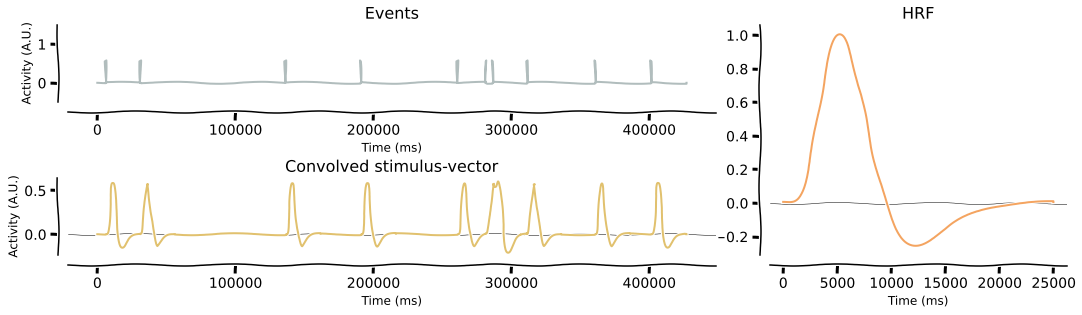

In [134]:
# define HRF
dt = 1/osf
time_points = np.linspace(0,25,np.rint(float(25)/dt).astype(int))
canonical_hrf = glm.double_gamma(time_points, lag=6)

# convolve with HRF
convolved_v = {}
for ii in dva_conds:
    convolved_v[ii] = glm.convolve_hrf(canonical_hrf, stims_v[str(ii)], make_figure=True, xkcd=True)

In [135]:
desired_scale = np.arange(0, int(size_response.shape[-1]), 1)

convolved_v_ds = {}
for ii in dva_conds:
    convolved_v_ds[ii] = glm.resample_stim_vector(convolved_v[ii], size_response.shape[-1])

In [146]:
# add some noise
synth_fmri = {}
noise_lvl = np.linspace(0.01,0.05,num=n_stims_select)
for ix,ii in enumerate(dva_conds):
    noise = np.random.normal(0, noise_lvl[ix], size_response.shape[-1])
    synth_fmri[ii] = (convolved_v_ds[ii]+noise).astype(float)

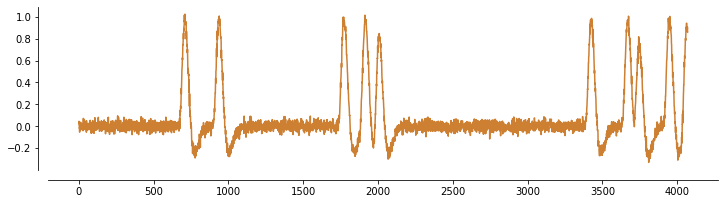

In [147]:
glm.plot_array(synth_fmri[dva_conds[3]])

In [148]:
TR = 0.105
data = pd.DataFrame(synth_fmri)
data['subject'], data['run'], data['t'] = 1, 1, list(TR*np.arange(data.shape[0]))
data = data.set_index(['subject', 'run', 't'])
data.head()

0.13      0.67      1.34      2.01      2.68      3.35  \
subject run t                                                                   
1       1   0.000  0.002232 -0.010138 -0.001502  0.023745  0.037012 -0.043505   
            0.105  0.005527 -0.009801 -0.002833  0.043824  0.017101  0.038235   
            0.210  0.019736 -0.012421  0.011623 -0.004552  0.073673 -0.003491   
            0.315  0.004177  0.038161  0.002843 -0.019188 -0.048675  0.016428   
            0.420 -0.008182  0.010793  0.034516 -0.016380 -0.037833 -0.061085   

                       4.02  
subject run t                
1       1   0.000 -0.027752  
            0.105 -0.012751  
            0.210  0.009553  
            0.315  0.010575  
            0.420 -0.023816

In [149]:
onset_df['subject'], onset_df['run'] = 1,1
onset_df['event_type'] = onset_df['event_type'].astype(str)
onset_df['onset'] = onset_df['onset'].astype(float)
onset_df2 = onset_df.set_index(['subject', 'run', 'event_type'])
onset_df2

onset
subject run event_type         
1       1   0.13          1.575
            4.02          5.985
            1.34         16.590
            2.68         20.895
            3.35         26.040
...                         ...
            1.34        392.385
            4.02        401.415
            2.01        409.290
            2.68        415.275
            2.01        421.470

[70 rows x 1 columns]

In [150]:
min_int = 0
max_int = 20
n_regres = None
fs = 1/TR

g_model = nd.GroupResponseFitter(data,
                                 onset_df2,
                                 input_sample_rate=fs,
                                 concatenate_runs=False,
                                 confounds=None, 
                                 add_intercept=False)

cond = onset_df2.reset_index().event_type.unique()
[g_model.add_event(i,
                  basis_set='fir',
                  n_regressors=n_regres,
                  interval=[min_int,max_int]) for i in cond]
           
g_model.fit()
print("Done")

Done


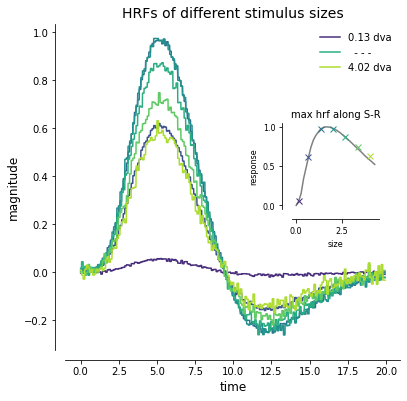

In [185]:
cols = sns.color_palette('viridis', dva_conds.shape[0])
tmp = g_model.get_subjectwise_timecourses().reset_index()

fig,axs = plt.subplots(figsize=(6,6))
max_vals = []
for idc,ii in enumerate(dva_conds):

    jj = tmp[(tmp['event type'] == str(ii))][ii].values
    xx = tmp[(tmp['event type'] == str(ii))]['time'].values

    axs.plot(xx,jj, color=cols[idc], label=f"{str(ii)} dva")
    sns.despine(offset=10)
    max_vals.append(np.amax(jj))
    
max_vals = np.array(max_vals)
    
plt.xlabel('time')
plt.ylabel('magnitude')

tmp_ax = plt.gca()
for item in ([tmp_ax.xaxis.label, tmp_ax.yaxis.label] +
             tmp_ax.get_xticklabels() + tmp_ax.get_yticklabels()):
    item.set_fontsize(12)

handles, labels = tmp_ax.get_legend_handles_labels()
middle = int(round(float(len(handles) / 2),0))
labels_new = [labels[0], '  - - -', labels[-1]]
handles_new = [handles[0], handles[middle], handles[-1]]
plt.legend(handles_new, labels_new, frameon=False)
plt.title('HRFs of different stimulus sizes').set_fontsize(14)
left, bottom, width, height = [0.65, 0.45, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
sns.despine(offset=10)
ax2.set_xlabel('size')
ax2.set_ylabel('response')
ax2.plot(stims_fill_sizes, mean_srf_fill, color=(128/255, 128/255, 128/255))

for ix,kk in enumerate(max_vals):
    ax2.plot(dva_conds.astype(float)[ix], kk, color=cols[ix], marker='x')

for item in ([ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(8)
    
ax2.set_title('max hrf along S-R')
ax2.title.set_fontsize(10)
    
plt.show()

In [160]:
middle = int(round(float(len(handles) / 2),0))
middle

4

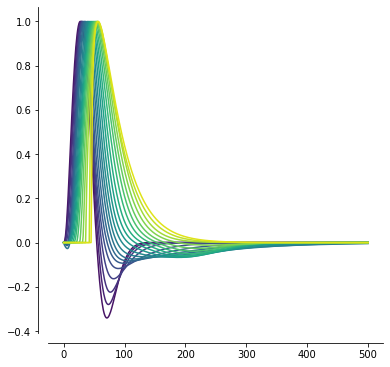

In [95]:
import pybest
hrfs_fn = opj(os.path.dirname(pybest.__file__), 'data', 'hrf_ts.mat')
hrfs_data = loadmat(hrfs_fn)['hrf_ts']

col_hrfs = sns.color_palette('viridis', hrfs_data.shape[-1])

fig,axs = plt.subplots(figsize=(6,6))

for hrf in range(hrfs_data.shape[-1]):
    plt.plot(hrfs_data[:,hrf], color=col_hrfs[hrf])
    sns.despine(offset=10)

In [93]:
hrfs_data.shape

(501, 20)

---
# Make some figures

In [ ]:
prf_array_new = prf.make_prf(prf_stim, size=new_params[2], mu_x=new_params[0], mu_y=params[1])
prf.plot_prf(prf_array_new, vf_extent)

In [ ]:
i, j = np.unravel_index(np.squeeze(prf_array_new, axis=0).argmax(), np.squeeze(prf_array_new, axis=0).shape)

i_ext = ((i/270)*10)-5
j_ext = ((j/270)*10)-5

In [ ]:
# https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
# very useful for plotting circles in matplotlib

fig, ax = plt.subplots(figsize=(6,6))
cmap_blue = make_binary_cm(8,178,240)
cmap_grey = make_binary_cm(230,230,230)
ax.axvline(0, color='k', linestyle='dashed', lw=0.5)
ax.axhline(0, color='k', linestyle='dashed', lw=0.5)
# ax.imshow(lib['vert'][use_settings['vert'][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
im = ax.imshow(np.squeeze(prf_array_new, axis=0), extent=vf_extent+vf_extent, cmap=cmap_blue)
ax.imshow(center_dot, extent=vf_extent+vf_extent, cmap=cmap_white)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData)
draw_circle = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData, fill=False, lw=2, clip_on=False)
draw_dot = patches.Circle((j_ext+0.04,-i_ext), radius=0.1, transform=ax.transData, fc=(1,1,1))

im.set_clip_path(patch)
# ax.add_artist(draw_circle)
ax.add_artist(draw_dot)
ax.axis('off')

plt.savefig(opj(fig_dir, 'prf_a.png'), transparant=True, dpi=600, bbox_inches='tight')


In [ ]:
# https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
# very useful for plotting circles in matplotlib

fig, ax = plt.subplots(figsize=(6,6))
cmap_blue = make_binary_cm(8,178,240)
cmap_grey = make_binary_cm(230,230,230)
ax.axvline(0, color='k', linestyle='dashed', lw=0.5)
ax.axhline(0, color='k', linestyle='dashed', lw=0.5)
im = ax.imshow(lib['vert'][use_settings['vert'][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
# im = ax.imshow(np.squeeze(prf_array_new, axis=0), extent=vf_extent+vf_extent, cmap=cmap_blue)
ax.imshow(center_dot, extent=vf_extent+vf_extent, cmap=cmap_white)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData)
draw_circle = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData, fill=False, lw=2, clip_on=False)
draw_dot = patches.Circle((j_ext+0.04,-i_ext), radius=0.1, transform=ax.transData, fc=(1,1,1))

# im.set_clip_path(patch)
# ax.add_artist(draw_circle)
# ax.add_artist(draw_dot)
ax.axis('off')

plt.savefig(opj(fig_dir, 'prf_b.png'), transparant=True, dpi=600, bbox_inches='tight')


In [ ]:
# https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
# very useful for plotting circles in matplotlib

fig, ax = plt.subplots(figsize=(6,6))
cmap_blue = make_binary_cm(8,178,240)
cmap_grey = make_binary_cm(230,230,230)
ax.axvline(0, color='k', linestyle='dashed', lw=0.5)
ax.axhline(0, color='k', linestyle='dashed', lw=0.5)
ax.imshow(lib['vert'][use_settings['vert'][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
im = ax.imshow(np.squeeze(prf_array_new, axis=0), extent=vf_extent+vf_extent, cmap=cmap_blue)
ax.imshow(center_dot, extent=vf_extent+vf_extent, cmap=cmap_white)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData)
draw_circle = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData, fill=False, lw=2, clip_on=False)
draw_dot = patches.Circle((j_ext+0.04,-i_ext), radius=0.1, transform=ax.transData, fc=(1,1,1))

im.set_clip_path(patch)
# ax.add_artist(draw_circle)
# ax.add_artist(draw_dot)
ax.axis('off')

plt.savefig(opj(fig_dir, 'prf_c.png'), transparant=True, dpi=600, bbox_inches='tight')


In [ ]:
dt = 1/100
time_points = np.linspace(0, 25, np.rint(float(25)/dt).astype(int))
canonical_hrf = glm.double_gamma(time_points, lag=6)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(canonical_hrf, color=(8/255, 178/255, 240/255))
# ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
# sns.despine(offset=10, trim=True)
ax.axis('off')
plt.savefig(opj(fig_dir, 'prf_d.png'), transparant=True, dpi=600, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(new_prediction, color=(8/255, 178/255, 240/255))
# ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
# sns.despine(offset=10, trim=True)
ax.axis('off')
plt.savefig(opj(fig_dir, 'prf_e.png'), transparant=True, dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(synth_fmri, color=(8/255, 178/255, 240/255))
# ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
# sns.despine(offset=10, trim=True)
ax.axis('off')
plt.savefig(opj(fig_dir, 'prf_f.png'), transparant=True, dpi=600, bbox_inches='tight')

In [ ]:
synth_fmri.shape

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(30,6))

# plot 1: pRF model
ax[0].axvline(0, color='k', linestyle='dashed', lw=0.5)
ax[0].axhline(0, color='k', linestyle='dashed', lw=0.5)
# ax.imshow(lib['vert'][use_settings['vert'][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
im = ax[0].imshow(np.squeeze(prf_array_new, axis=0), extent=vf_extent+vf_extent, cmap=cmap_blue)
ax[0].imshow(center_dot, extent=vf_extent+vf_extent, cmap=cmap_white)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax[0].transData)
draw_circle = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax[0].transData, fill=False, lw=2, clip_on=False)
draw_dot = patches.Circle((j_ext+0.04,-i_ext), radius=0.1, transform=ax[0].transData, fc=(1,1,1))

im.set_clip_path(patch)
# ax.add_artist(draw_circle)
ax[0].add_artist(draw_dot)
ax[0].axis('off')


# plot 2: stimulus aperture
ax[1].axvline(0, color='k', linestyle='dashed', lw=0.5)
ax[1].axhline(0, color='k', linestyle='dashed', lw=0.5)
im = ax[1].imshow(lib['vert'][use_settings['vert'][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
# im = ax.imshow(np.squeeze(prf_array_new, axis=0), extent=vf_extent+vf_extent, cmap=cmap_blue)
ax[1].imshow(center_dot, extent=vf_extent+vf_extent, cmap=cmap_white)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax[1].transData)
draw_circle = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax[1].transData, fill=False, lw=2, clip_on=False)
draw_dot = patches.Circle((j_ext+0.04,-i_ext), radius=0.1, transform=ax[1].transData, fc=(1,1,1))

# im.set_clip_path(patch)
# ax.add_artist(draw_circle)
# ax.add_artist(draw_dot)
ax[1].axis('off')


# plot 3: stimulus X pRF-model
ax[2].axvline(0, color='k', linestyle='dashed', lw=0.5)
ax[2].axhline(0, color='k', linestyle='dashed', lw=0.5)
ax[2].imshow(lib['vert'][use_settings['vert'][1]], extent=vf_extent+vf_extent, cmap=cmap_grey, alpha=alpha)
im = ax[2].imshow(np.squeeze(prf_array_new, axis=0), extent=vf_extent+vf_extent, cmap=cmap_blue)
ax[2].imshow(center_dot, extent=vf_extent+vf_extent, cmap=cmap_white)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax[2].transData)
draw_circle = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax[2].transData, fill=False, lw=2, clip_on=False)
draw_dot = patches.Circle((j_ext+0.04,-i_ext), radius=0.1, transform=ax[2].transData, fc=(1,1,1))

im.set_clip_path(patch)
# ax.add_artist(draw_circle)
# ax.add_artist(draw_dot)
ax[2].axis('off')

# plot 4: hrf
ax[3].plot(canonical_hrf, color=(8/255, 178/255, 240/255))
ax[3].axis('off')


# plot 5: prediction
ax[4].plot(new_prediction, color=(8/255, 178/255, 240/255))
ax[4].axis('off')

# plot 6: data
ax[5].plot(synth_fmri, color=(8/255, 178/255, 240/255))
ax[5].axis('off')

plt.savefig(opj(fig_dir, 'prf_g.png'), transparant=True, dpi=600, bbox_inches='tight')